# Import libraries

In [1]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
from sage import MarginalImputer, PermutationEstimator

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

from compute_rf_feature_importance import compute_rf_feature_importance

# Generate a gaussian linear model for a given design of causal probabilistic graph

In [2]:
def generate_gaussian_causal_network(
    n_sample=1000,
    b=np.zeros(10),
    v=np.ones(10),
    w=np.vstack([np.zeros((9, 10)), np.ones((1, 10))]),
    random_state=None,
):
    """
    Generate samples of D gaussian rvs whose interactions are modeled by a Directed Acyclic Graph.
    We assume the variables are numbered so that if `j \\in pa_i` then `j<i`.
    The conditional of `x_i` conditioned on its parents `pa_i` is `p(x_i|pa_i) = \\mathcal{N}(x_i | \\sum_{j \\in pa_i w_{i,j}x_j + b_i , v_i})`

    Parameters
    ----------
    n_samples : int 
        The number of samples to draw.
    b : ndarray of shape (D,)
        The bias term of each random variable.
    v : ndarray of shape (D,)
        The variance term of each random variable.
    w : ndarray of shape (D, D)
        The weights representing the conditional relation between i and its parent j.
        Zero if i and j are marginally independant.
    random_state : int
        Seed of the random number generator.

    Returns
    ----------
    X : ndarray of shape (n_samples, D)
        The drawn samples.
    mu : ndarray of shape (D,)
        The theoretical mean vector of the multivariate gaussian.
    Sigma : ndarray of shape (D, D)
        The theoretical variance-covariance matrix of the multivariate gaussian.
    Note
    ----------
    - The random variables follows a multivariate gaussian distribution whose mean and covariance matrix can be computed recursively
        in the following manner (Bishop, section 8.1.4):
        - `\\mu_i = \\sum_{j \\in pa_i} w_{i,j} \\mu_j + b_i`
        - `\\Sigma_{i,j} = \\sum_{k \\in pa_j} w_{j,k} \\Sigma_{i,k} + I_{i=j}v_i`
    - The default is a model where the first 9 variables are sampled from independant standard distributions, and the last from a normal distribution
        centered on the sum of covariates and with variance 1. Essentially a simple linear model.
    """
    rng = check_random_state(random_state)
    D = b.shape[0]
    mu = np.zeros(D)
    Sigma = np.zeros((D, D))

    for i in range(D):
        mu[i] = b[i]
        for j in range(D):
            mu[i] += w[i, j] * mu[j]
        
        for j in range(i, D):
            Sigma[i, j] = (i == j) * v[i]
            for k in range(D):
                Sigma[i, j] += w[j, k] * Sigma[i, k]
            Sigma[j, i] = Sigma[i, j]
        

    X = rng.multivariate_normal(mu, Sigma, n_sample)
    return X, mu, Sigma


# Compute the exact SAGE values for this model

In [3]:
def expected_conditional_variance_reduction(S, i, idx_y, Sigma):
    """
    Computes the expected variance reduction in the conditional expectation of Y
    when adding feature X_i to a conditioning set X_S, under the assumption that
    we generated the model with generate_causal_gaussian_lm()

    The quantity computed is:
        `E[Var(E[Y | X_S, X_i] | X_S)] = E[Var(Y | X_S)] - E[Var(Y | X_S, X_i)]`

    Since we know the covariance matrix of (X,Y), by property of multivariate gaussian random variables, this simplifies as:
        `(Sigma_yy - Sigma_yS Sigma_SS^-1 Sigma_Sy) - (Sigma_yy - Sigma_yA Sigma_AA^-1 Sigma_Ay)`
        `= Sigma_yA Sigma_AA^-1 Sigma_Ay - Sigma_yS Sigma_SS^-1 Sigma_Sy `
    when we let `A := S \\cup {i}`

    Parameters
    ----------
    S : list or array of int
        indices of features in the conditioning set X_S
    i : int
        index of the feature X_i to evaluate (must not be in S)
    idx_y : int
        index of the target in the multivariate gaussian vector.
    Sigma : ndarray of shape (n_features + 1, n_features + 1)
        The variance-covariance matrix of the multivariate gaussian (X, Y).
    
    Returns
    ----------
    out : float
        the expected conditional variance reduction
    """
    S = list(S)
    if i in S:
        raise ValueError("Feature index i should not be in S")

    A = S + [i]

    # Extract relevant submatrices from Sigma
    Sigma_SS = Sigma[np.ix_(S, S)]
    Sigma_yS = Sigma[np.ix_([idx_y], S)]
    Sigma_Sy = Sigma[np.ix_(S, [idx_y])]

    Sigma_AA = Sigma[np.ix_(A, A)]
    Sigma_yA = Sigma[np.ix_([idx_y], A)]
    Sigma_Ay = Sigma[np.ix_(A, [idx_y])]

    # Compute conditional covariances
    left_term = Sigma_yA @ np.linalg.solve(Sigma_AA, Sigma_Ay)
    right_term = Sigma_yS @ np.linalg.solve(Sigma_SS, Sigma_Sy)

    return left_term - right_term


In [4]:
def compute_bayes_sage(D, i, idx_y, Sigma):
    """
    Computes the average marginal contribution of feature i for the Bayes model:

        `(1/d) * sum_{S \\subseteq D^{-i}} (1 / C(d-1, |S|)) * E[Var(E[Y | X_S, X_i] | X_S)]`

    where:
    - `D` is the set of all feature indices
    - S runs over all subsets of `D^{-i}`
    - (X,Y) was generated with generate_causal_gaussian_lm()

    Parameters
    ----------
    D : ndarray of shape (n_features,)
        The indices of the features in the multivariate gaussian vector.
    i : int
        The index of the feature of interest.
    idx_y : int
        The index of the target in the multivariate gaussian vector.
    Sigma : ndarray of shape (n_features + 1, n_features + 1)
        The variance-covariance matrix of the multivariate gaussian (X, Y).

    Returns
    ----------
    - out : float
        SAGE value of feature i for the optimal model
    """
    assert i != idx_y
    d = len(D)
    D_minus_i = [j for j in D if j != i]
    total = 0.0
    for k in range(d):  # |S| = 0 to d-1
        subsets_of_size_k = list(itertools.combinations(D_minus_i, k))
        weight = 1 / math.comb(d - 1, k)
        for S in subsets_of_size_k:
            v = expected_conditional_variance_reduction(S, i, idx_y, Sigma)
            total += weight * v
    return total / d


# Define the parameters of the training loop and the model

In [ ]:
# We will first consider the following DAG (arrows are directed downwards):
#           x_0
#            |
#       x_1 x_2
#    x_3  \  | \
#      \   \ |  \
#       x_4 x_5  x_6
#         \ /
#         x_7
# x_5 will be the target. Its Markov Blanket is (x_1, x_2, x_4, x_7) so we want these 
# features to receive the highest importance.
# The only non zero weights will be w_2,0 ; w_4,3 ; w_5,1 ; w_5,2 ; w_6,2 ; w_7,4 ; w_7,5
# We choose arbitrary values for the weight, bias and variance terms and therefore define:

#             x0  x1 x2 x3 x4 x5 x6 x7
b = np.array([1, -1, 0, 2, 1, 2, -2, 3])

#              x0   x1   x2   x3   x4   x5   x6   x7
v = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

w = np.array(
    [
        # x0   x1   x2   x3   x4   x5   x6   x7
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x0
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x1
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x2
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x3
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],  # x4
        [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x5
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x6
        [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],  # x7
    ]
)

idx_target = 5
idx_features = [i for i in range(8) if i != idx_target]
n_feature = len(idx_features)

In [6]:
# Training loop parameters
train_sizes = np.logspace(2, 4, 7, dtype=int)
test_size = int(1e3)
n_folds = 5
rng = np.random.RandomState(42)
n_estimators = 100

# Training loop and feature importance measures

In [7]:
mdi_res = np.zeros((len(train_sizes), n_feature))
ufi_res = np.zeros((len(train_sizes), n_feature))
mdi_oob_res = np.zeros((len(train_sizes), n_feature))
j_score_res = np.zeros((len(train_sizes), n_feature))
j_score_test_res = np.zeros((len(train_sizes), n_feature))
sage_res = list()
permut_res = list()
mse_improvement = np.zeros(len(train_sizes))

for train_size_idx, train_size in enumerate(train_sizes):
    Xy, mu, Sigma = generate_gaussian_causal_network(
        n_sample=train_size + test_size,
        b=b,
        v=v,
        w=w,
        random_state=rng,
    )
    X, y = Xy[:, idx_features], Xy[:, idx_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=rng
    )
    reg = RandomForestRegressor(
        n_estimators=n_estimators,
        oob_score=True,
        n_jobs=-1,
        random_state=rng,
    ).fit(X_train, y_train)

    mdi_res[train_size_idx, :] = reg._unnormalized_feature_importances
    feature_importance_res = compute_rf_feature_importance(reg, X_train, y_train, "mse" , ["UFI", "MDI-oob", "j-score", "j-score_test"], X_test, y_test)
    ufi_res[train_size_idx, :] = feature_importance_res["UFI"]
    mdi_oob_res[train_size_idx, :] = feature_importance_res["MDI-oob"]
    j_score_res[train_size_idx, :] = feature_importance_res["j-score"]
    j_score_test_res[train_size_idx, :] = feature_importance_res["j-score_test"]
    imputer = MarginalImputer(reg, X_test[:500])
    estimator = PermutationEstimator(imputer, "mse", random_state=rng)
    sage_res.append(
        estimator(X_test, y_test, thresh=0.05, bar=False)
    )
    # permut_res.append(
    #     permutation_importance(reg, X_test, y_test, n_repeats=5, random_state=rng)
    # )

    dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)

    mse_improvement[train_size_idx] = mean_squared_error(
        y_test, dummy.predict(X_test)
    ) - mean_squared_error(y_test, reg.predict(X_test))


In [8]:
bayes_sage = [compute_bayes_sage(idx_features, i, idx_target, Sigma) for i in idx_features]
bayes_sage

[array([[0.13975428]]),
 array([[0.30082721]]),
 array([[0.38557559]]),
 array([[0.01696568]]),
 array([[0.08427779]]),
 array([[0.20050607]]),
 array([[0.62209338]])]

In [9]:
mse_improvement

array([1.53112638, 1.69399319, 1.58851795, 1.75395542, 1.77125417,
       1.82993688, 1.75595572])

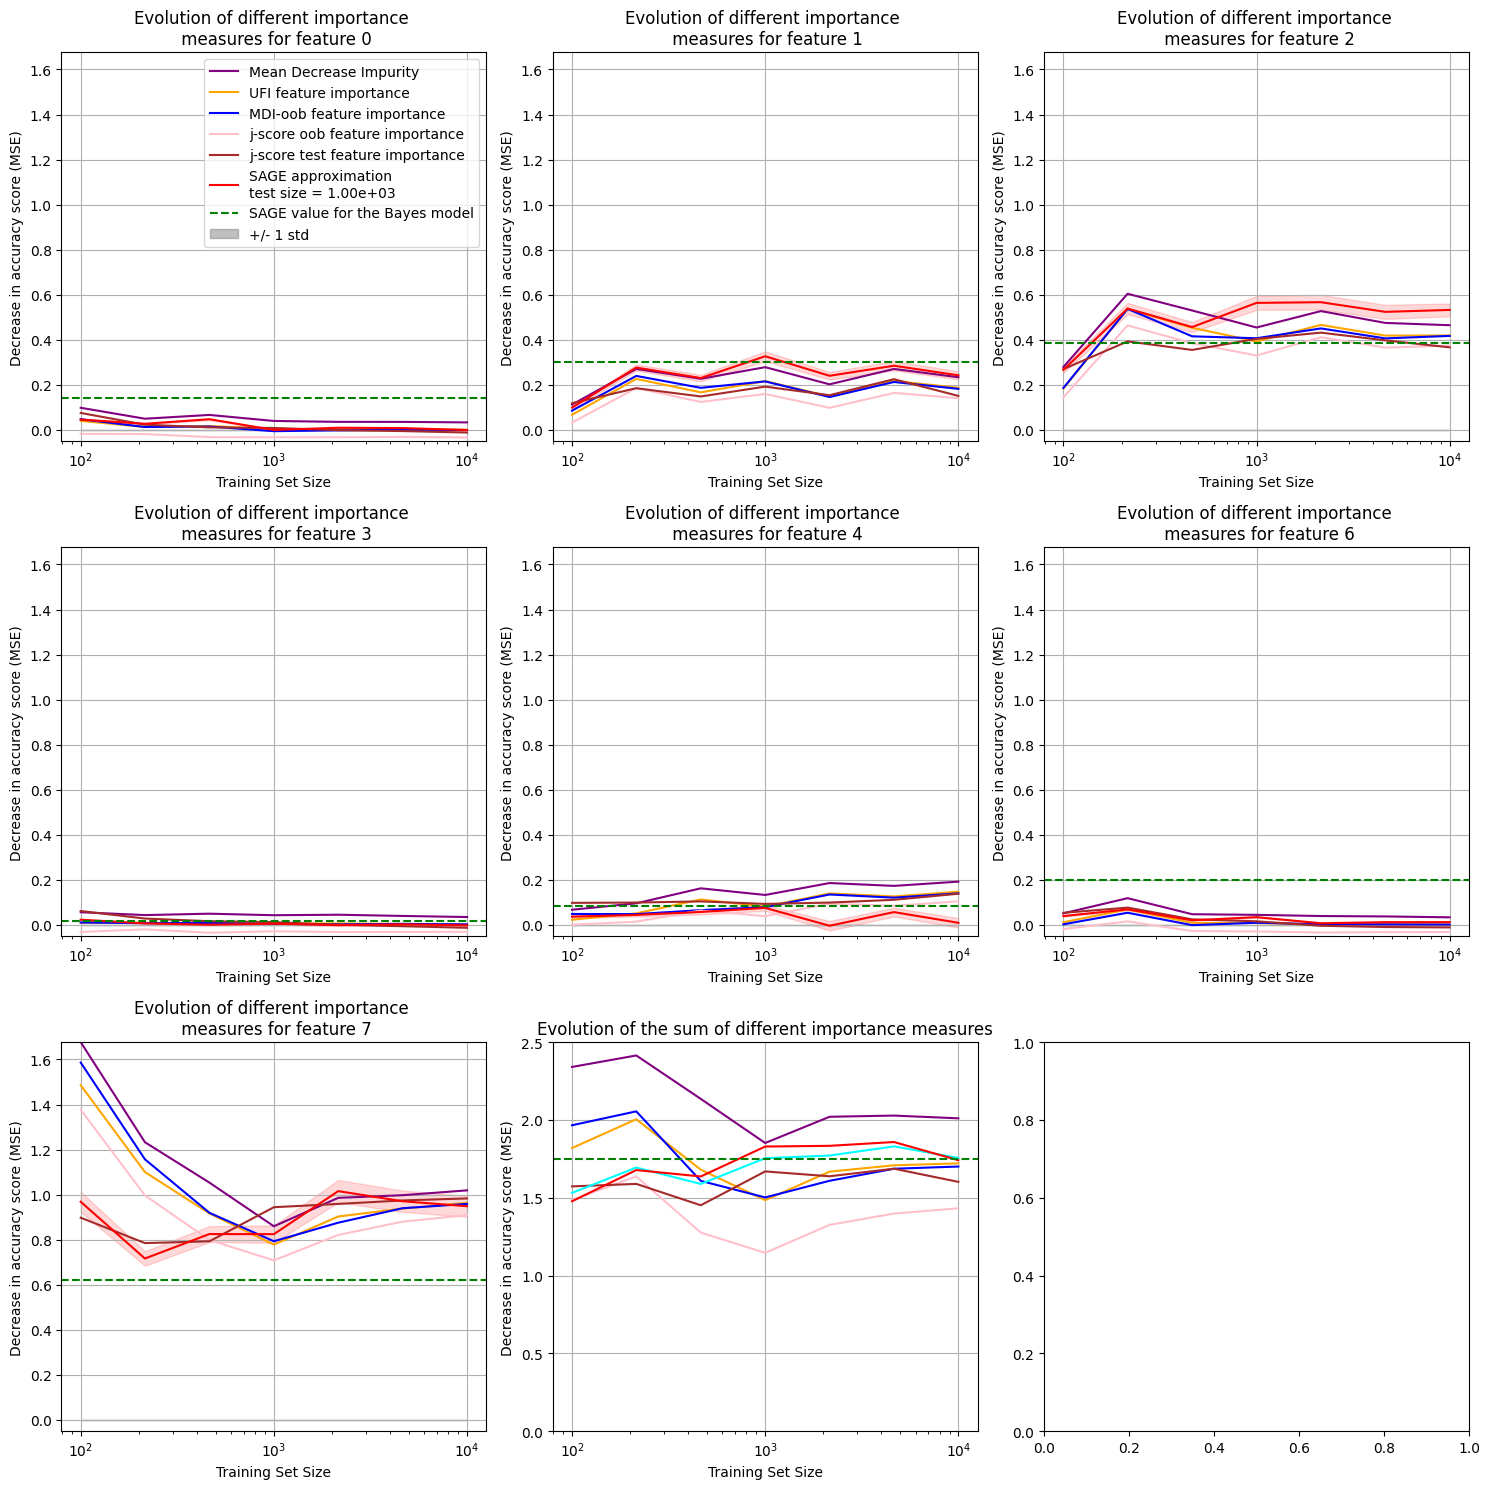

In [11]:
global_max = np.max(
    [
        mdi_res,
        ufi_res,
        mdi_oob_res,
        j_score_res,
        j_score_test_res,
        [sage_res[j].values + sage_res[j].std for j in range(len(train_sizes))],
        # [
        #     permut_res[j].importances_mean + permut_res[j].importances_std
        #     for j in range(len(train_sizes))
        # ],
    ]
)

# Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i in range(n_feature):
    axs[i].set_ylim(-0.05, global_max)
    axs[i].plot(
        train_sizes, mdi_res[:, i], label="Mean Decrease Impurity", color="purple"
    )
    axs[i].plot(
        train_sizes, ufi_res[:, i], label="UFI feature importance", color="orange"
    )
    axs[i].plot(
        train_sizes, mdi_oob_res[:, i], label="MDI-oob feature importance", color="blue"
    )
    axs[i].plot(
        train_sizes, j_score_res[:, i], label="j-score oob feature importance", color="pink"
    )
    axs[i].plot(
        train_sizes, j_score_test_res[:, i], label="j-score test feature importance", color="brown"
    )
    axs[i].plot(
        train_sizes,
        [sage_res[j].values[i] for j in range(len(train_sizes))],
        label=f"SAGE approximation \ntest size = {test_size:.2e}",
        color="red",
    )
    axs[i].fill_between(
        train_sizes,
        [sage_res[j].values[i] + sage_res[j].std[i] for j in range(len(train_sizes))],
        [sage_res[j].values[i] - sage_res[j].std[i] for j in range(len(train_sizes))],
        color="red",
        alpha=0.15,
    )
    # axs[i].plot(
    #     train_sizes,
    #     [permut_res[j].importances_mean[i] for j in range(len(train_sizes))],
    #     label=f"permutation importance \ntest size = {test_size:.2e}",
    #     color="cyan",
    # )
    # axs[i].fill_between(
    #     train_sizes,
    #     [
    #         permut_res[j].importances_mean[i] + permut_res[j].importances_std[i]
    #         for j in range(len(train_sizes))
    #     ],
    #     [
    #         permut_res[j].importances_mean[i] - permut_res[j].importances_std[i]
    #         for j in range(len(train_sizes))
    #     ],
    #     color="cyan",
    #     alpha=0.15,
    # )
    axs[i].axhline(bayes_sage[i], ls="--", label="SAGE value for the Bayes model", color="green")
    # axs[i].axhline(model_weights[i], ls="-.", label="Weight in the model", color="black")
    axs[i].fill_between(train_sizes, 0, 0, color="gray", alpha=0.5, label="+/- 1 std")
    axs[i].set_xscale("log")
    axs[i].set_xlabel("Training Set Size")
    axs[i].set_ylabel("Decrease in accuracy score (MSE)")
    axs[i].set_title(
        f"Evolution of different importance \n measures for feature {idx_features[i]}"
    )
    axs[i].grid(True)

axs[n_feature].set_ylim(0, 2.5)
axs[n_feature].plot(
    train_sizes, mdi_res.sum(axis=1), label="Sum of MDI", color="purple"
)
axs[n_feature].plot(
    train_sizes, ufi_res.sum(axis=1), label="Sum of UFI", color="orange"
)
axs[n_feature].plot(
    train_sizes, mdi_oob_res.sum(axis=1), label="Sum of MDI-oob", color="blue"
)
axs[n_feature].plot(
    train_sizes, j_score_res.sum(axis=1), label="sum of j-score oob", color="pink"
)
axs[n_feature].plot(
    train_sizes, j_score_test_res.sum(axis=1), label="sum of j-score test", color="brown"
)
axs[n_feature].plot(
    train_sizes, mse_improvement, label="MSE improvement wrt null model", color="cyan"
)
axs[n_feature].plot(
    train_sizes,
    [sage_res[j].values.sum() for j in range(len(train_sizes))],
    label=f"sum of SAGE approximation \ntest size = {test_size:.2e}",
    color="red",
)
axs[n_feature].axhline(sum(bayes_sage), ls="--", label="Sum of SAGE value for the Bayes model", color="green")
axs[n_feature].set_xscale("log")
axs[n_feature].set_xlabel("Training Set Size")
axs[n_feature].set_ylabel("Decrease in accuracy score (MSE)")
axs[n_feature].set_title(
    "Evolution of the sum of different importance measures"
)
axs[n_feature].grid(True)
axs[0].legend()
# axs[n_feature].legend()

plt.tight_layout()
plt.show()
